In [1]:
import json
import codecs
from collections import OrderedDict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statistics as st
import pandas as pd
from MFDFA import MFDFA
import os
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
first_partition = "H:/Вова/First debates/Partitions/first-debate_partition_{}.json"
# text -> full_text in first
second_partition = "H:/Вова/Second debates/Partitions/second-debate_partition_{}.txt"
third_partition = "H:/Вова/Third debates/Partitions/third-debate_partition_{}.txt"

In [4]:
def get_portion(path, last_pos):
    local_data = []
    with open(path.format(last_pos), "r+", encoding="utf-8") as partition_reader:
        partition = partition_reader.readlines()
        for line in partition:
            local_data.append(json.loads(line))
    last_pos += 1
    return local_data, last_pos

In [5]:
def patient_zero(path):
#     Удаляем всё после последнего /, потому что имя файла не нужно при получении списка файлов в папке
    folder = ""
    a = path.split("/")
    del a[-1]
    for item in a:
        folder += "{}/".format(item)
    
    number = 1
    last_pos = 0
    
    while last_pos != len(os.listdir(folder)):
        tmp = get_portion(path, last_pos)

        local_data = tmp[0]
        last_pos = tmp[1]
        
        local_data = list(filter(lambda x: (not x['text'].startswith("@{0}'s account".format(x['user']['screen_name']))), local_data))
        local_data = list(filter(lambda x: (not "retweeted_status" in x), local_data))
        local_data = list(filter(lambda x: (not "quoted_status" in x), local_data))  

        for tweet in local_data:
            with codecs.open("Level_0_{0}.txt".format(last_pos - 1), 'a', 'utf_8_sig') as file:
                file.write("{0}\n".format(json.dumps(
                    {"id": tweet['id'],
                     "number": number,
                     "screen_name": tweet['user']['screen_name'],
                     "retweet_count": tweet['retweet_count'],
                     "created_at": tweet["created_at"],
                     "full_text": tweet["text"]
                     })))
            number += 1

        print("Iteration: {0}, Number: {1}".format(last_pos - 1, number), end='\r')

In [6]:
def level_one():
    iteration = 1
    number = 1
    last_pos = 0

    with zip.ZipFile('first-debate.zip') as zf:
        size = zf.getinfo("first-debate.json").file_size

    zero = collect_zero()

    while last_pos != size:
        tmp = get_portion(last_pos)

        local_data = tmp[0]
        last_pos = tmp[1]

        for item in zero:
            match = []
            for tweet in local_data:
                try:
                    if tweet['retweeted_status']['id'] == item['id']:
                        match.append(tweet)
                except KeyError:
                    pass

            for tweet in match:
                with codecs.open("Level_1_{0}.txt".format(last_pos - 1), 'a', 'utf_8_sig') as file:
                    file.write("{0}\n".format(json.dumps(
                        {"id": tweet['id'],
                         "number": number,
                         "number_pr": item["number"],
                         "screen_name": tweet['user']['screen_name'],
                         "retweet_count": tweet['retweet_count'],
                         "created_at": tweet["created_at"],
                         "full_text": tweet["text"]
                         })))
            number += 1
        print("Iteration: {0}, Number: {1}".format((last_pos - 1), number))

In [7]:
first_zero = "H:/Вова/First debates/Level_0/"
second_zero = "H:/Вова/Second debates/Level_0/"
third_zero = "H:/Вова/Third debates/Level_0/"

In [8]:
def collect_zero(path):
    zero = []
    
    for filename in os.listdir(path):
        with open(path + filename, 'r') as fp:
            tmp = fp.readlines()
            for string in tmp:
                zero.append(json.loads(codecs.decode(string.encode(), "utf-8-sig").rstrip().replace("п»ї", "")))
    
    for item in zero:
        item['sorter'] = datetime.strptime(item['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
    
    zero = sorted(zero, key=lambda k: k['sorter'])
    
    return zero

In [9]:
# Динамика числа ретвитов во времени
def Rt(zero): 
    x = []
    y = []
    count = {}

    for item in zero:
        tmp = int(datetime.strptime(item["created_at"], '%a %b %d %H:%M:%S +0000 %Y').timestamp() // 10)
        if tmp in count.keys():
            count[tmp] += item["retweet_count"]
        else:
            count[tmp] = item["retweet_count"]

    for key, value in count.items():
        x.append(datetime.fromtimestamp(key * 10))
        y.append(value)
    
    fig, ax = plt.subplots(figsize=(19.20 * 2,10.80 * 2))
    
    days = mdates.DayLocator(interval = 1)
    d_fmt = mdates.DateFormatter('%Y/%m/%d')
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H')

    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('R(t)', fontsize=10)
    ax.plot(x, y)
    
    #     Подстветить время первых дебатов
#     plt.axvspan(datetime(2016, 9, 27, 1), datetime(2016, 9, 27, 2, 30), color='red', alpha=0.5)
    #     Подстветить время вторых дебатов
#     plt.axvspan(datetime(2016, 10, 10, 1), datetime(2016, 10, 10, 2, 30), color='red', alpha=0.5) 
    #     Подстветить время третьих дебатов
#     plt.axvspan(datetime(2016, 10, 20, 1), datetime(2016, 10, 20, 2, 30), color='red', alpha=0.5) 
    
    ax.xaxis.set_major_locator(days)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10000))
    ax.xaxis.set_major_formatter(d_fmt)
    ax.xaxis.set_minor_locator(hours)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
    ax.xaxis.set_minor_formatter(h_fmt)
    fig.autofmt_xdate()
    
    fig.savefig('Rt.svg', format='svg')
    
    return x,y

In [10]:
# Число источников зарождения ретвитов
def Nt(zero):
    x = []
    y = []
    count = {}

    for item in zero:
        tmp = int(datetime.strptime(item["created_at"], '%a %b %d %H:%M:%S +0000 %Y').timestamp() // 10)
        if tmp in count.keys():
            count[tmp] += 1
        else:
            count[tmp] = 1
    
    for key, value in count.items():
        x.append(datetime.fromtimestamp(key * 10))
        y.append(value)

    fig, ax = plt.subplots(figsize=(19.20 * 2,10.80 * 2))
    
    days = mdates.DayLocator(interval = 1)
    d_fmt = mdates.DateFormatter('%Y/%m/%d')
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H')
    
    ax.fill_between(x, y, alpha=0.5)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel("N(t)", fontsize=10)
    ax.plot(x, y, alpha=0.5)
    
    #     Подстветить время первых дебатов
#     plt.axvspan(datetime(2016, 9, 27, 1), datetime(2016, 9, 27, 2, 30), color='red', alpha=0.5)
    #     Подстветить время вторых дебатов
#     plt.axvspan(datetime(2016, 10, 10, 1), datetime(2016, 10, 10, 2, 30), color='red', alpha=0.5) 
    #     Подстветить время третьих дебатов
#     plt.axvspan(datetime(2016, 10, 20, 1), datetime(2016, 10, 20, 2, 30), color='red', alpha=0.5) 
    
    ax.xaxis.set_major_locator(days)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_major_formatter(d_fmt)
    ax.xaxis.set_minor_locator(hours)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_formatter(h_fmt)
    fig.autofmt_xdate()
    
    fig.savefig('Nt.svg', format='svg')
    
    return x,y

In [11]:
# Статистически средняя длина цепочки
def R_Nt(x, y, X, Y):
    y = np.array(y, dtype=np.float)
    Y = np.array(Y, dtype=np.float)
    Yn = y/Y
    
    fig, ax = plt.subplots(figsize=(19.20 * 2,10.80 * 2))
    
    days = mdates.DayLocator(interval = 1)
    d_fmt = mdates.DateFormatter('%Y/%m/%d')
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H')

    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel("R(t)/N(t)", fontsize=10)
    ax.plot(x, Yn)
    
    #     Подстветить время первых дебатов
#     plt.axvspan(datetime(2016, 9, 27, 1, 00, 00), datetime(2016, 9, 27, 2, 30, 00), color='red', alpha=0.5)
    #     Подстветить время вторых дебатов
#     plt.axvspan(datetime(2016, 10, 10, 1), datetime(2016, 10, 10, 2, 30), color='red', alpha=0.5) 
    #     Подстветить время третьих дебатов
#     plt.axvspan(datetime(2016, 10, 20, 1), datetime(2016, 10, 20, 2, 30), color='red', alpha=0.5) 
    
    ax.xaxis.set_major_locator(days)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10000))
    ax.xaxis.set_major_formatter(d_fmt)
    ax.xaxis.set_minor_locator(hours)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
    ax.xaxis.set_minor_formatter(h_fmt)
    fig.autofmt_xdate()
    
    fig.savefig('R_Nt.svg', format='svg')
    
    return x, Yn

In [12]:
def list_hours(zero):
    dates = []

    for item in zero:
        tmp = int(datetime.strptime(item["created_at"], '%a %b %d %H:%M:%S +0000 %Y').timestamp() // 3600)  
        dates.append(datetime.fromtimestamp(tmp * 3600).strftime('%a %b %d %H:%M:%S +0000 %Y'))
    
    return list(set(dates))

In [27]:
def My_MFDFA(y, Y, Yn):
    lag = np.logspace(0.7, 4, 30).astype(int)
    
    count = 0
    Q = [-5, -3, -1, 1, 3, 5]
    order = 1
    
    Ys = [np.array(y), np.array(Y), np.array(Yn)]
    Ys_dfa = [[], [], []]
    
    for item in Ys:
        for q in Q:
            lag, dfa = MFDFA(item, lag = lag, q = q, order = order)
            Ys_dfa[count].append(dfa)
            Ys_dfa[count].append(np.polyfit(np.log(lag[8:18]), np.log(dfa[8:18]),1)[0][0])
#             Ys_dfa[count].append(np.polyfit(np.log(lag[:15]), np.log(dfa[:15]),1)[0][0])
        count += 1
    
    return Ys_dfa

In [41]:
zero = collect_zero(first_zero)

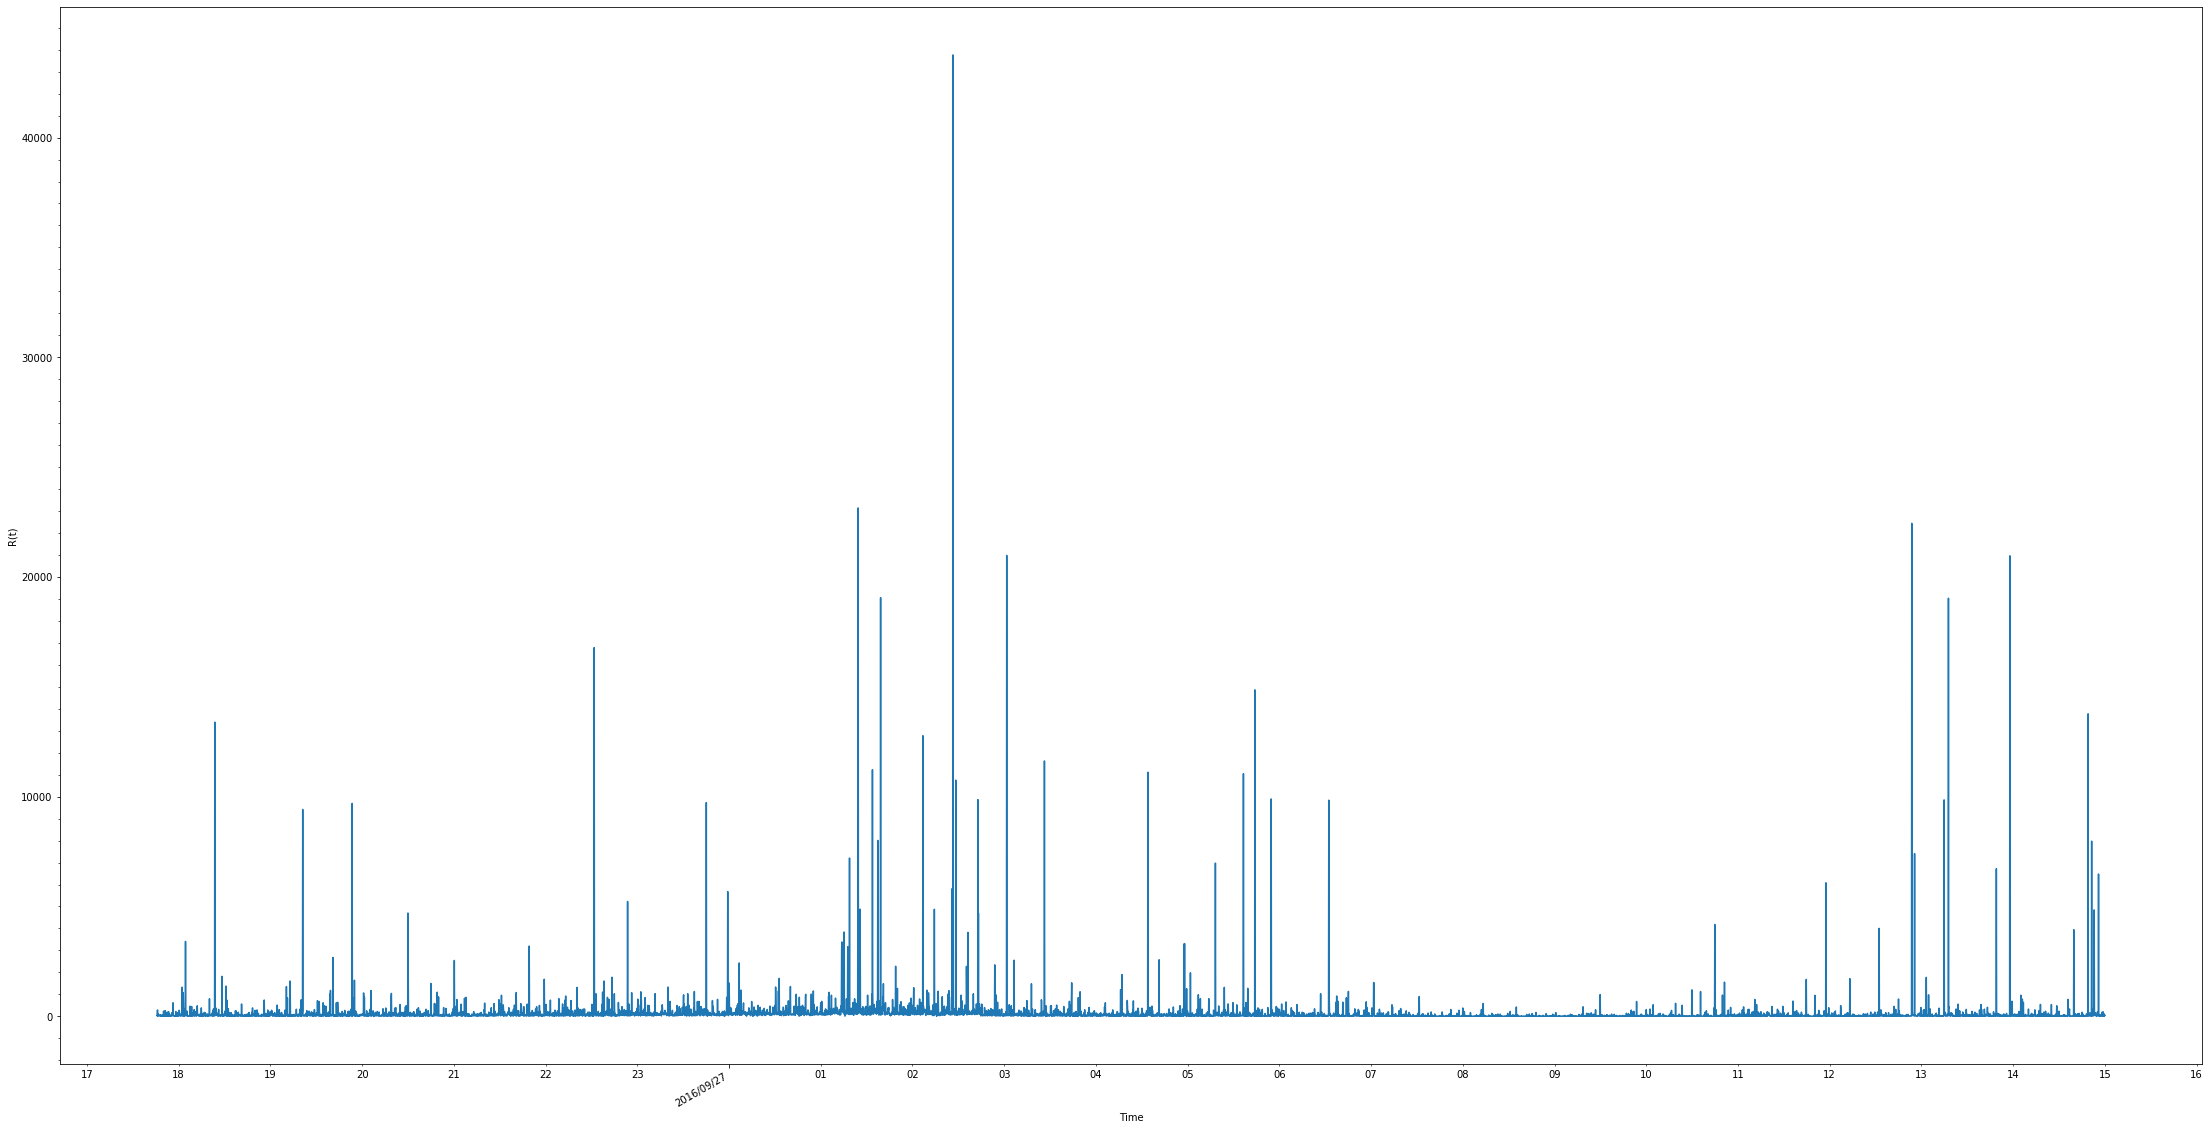

In [42]:
x, y = Rt(zero)

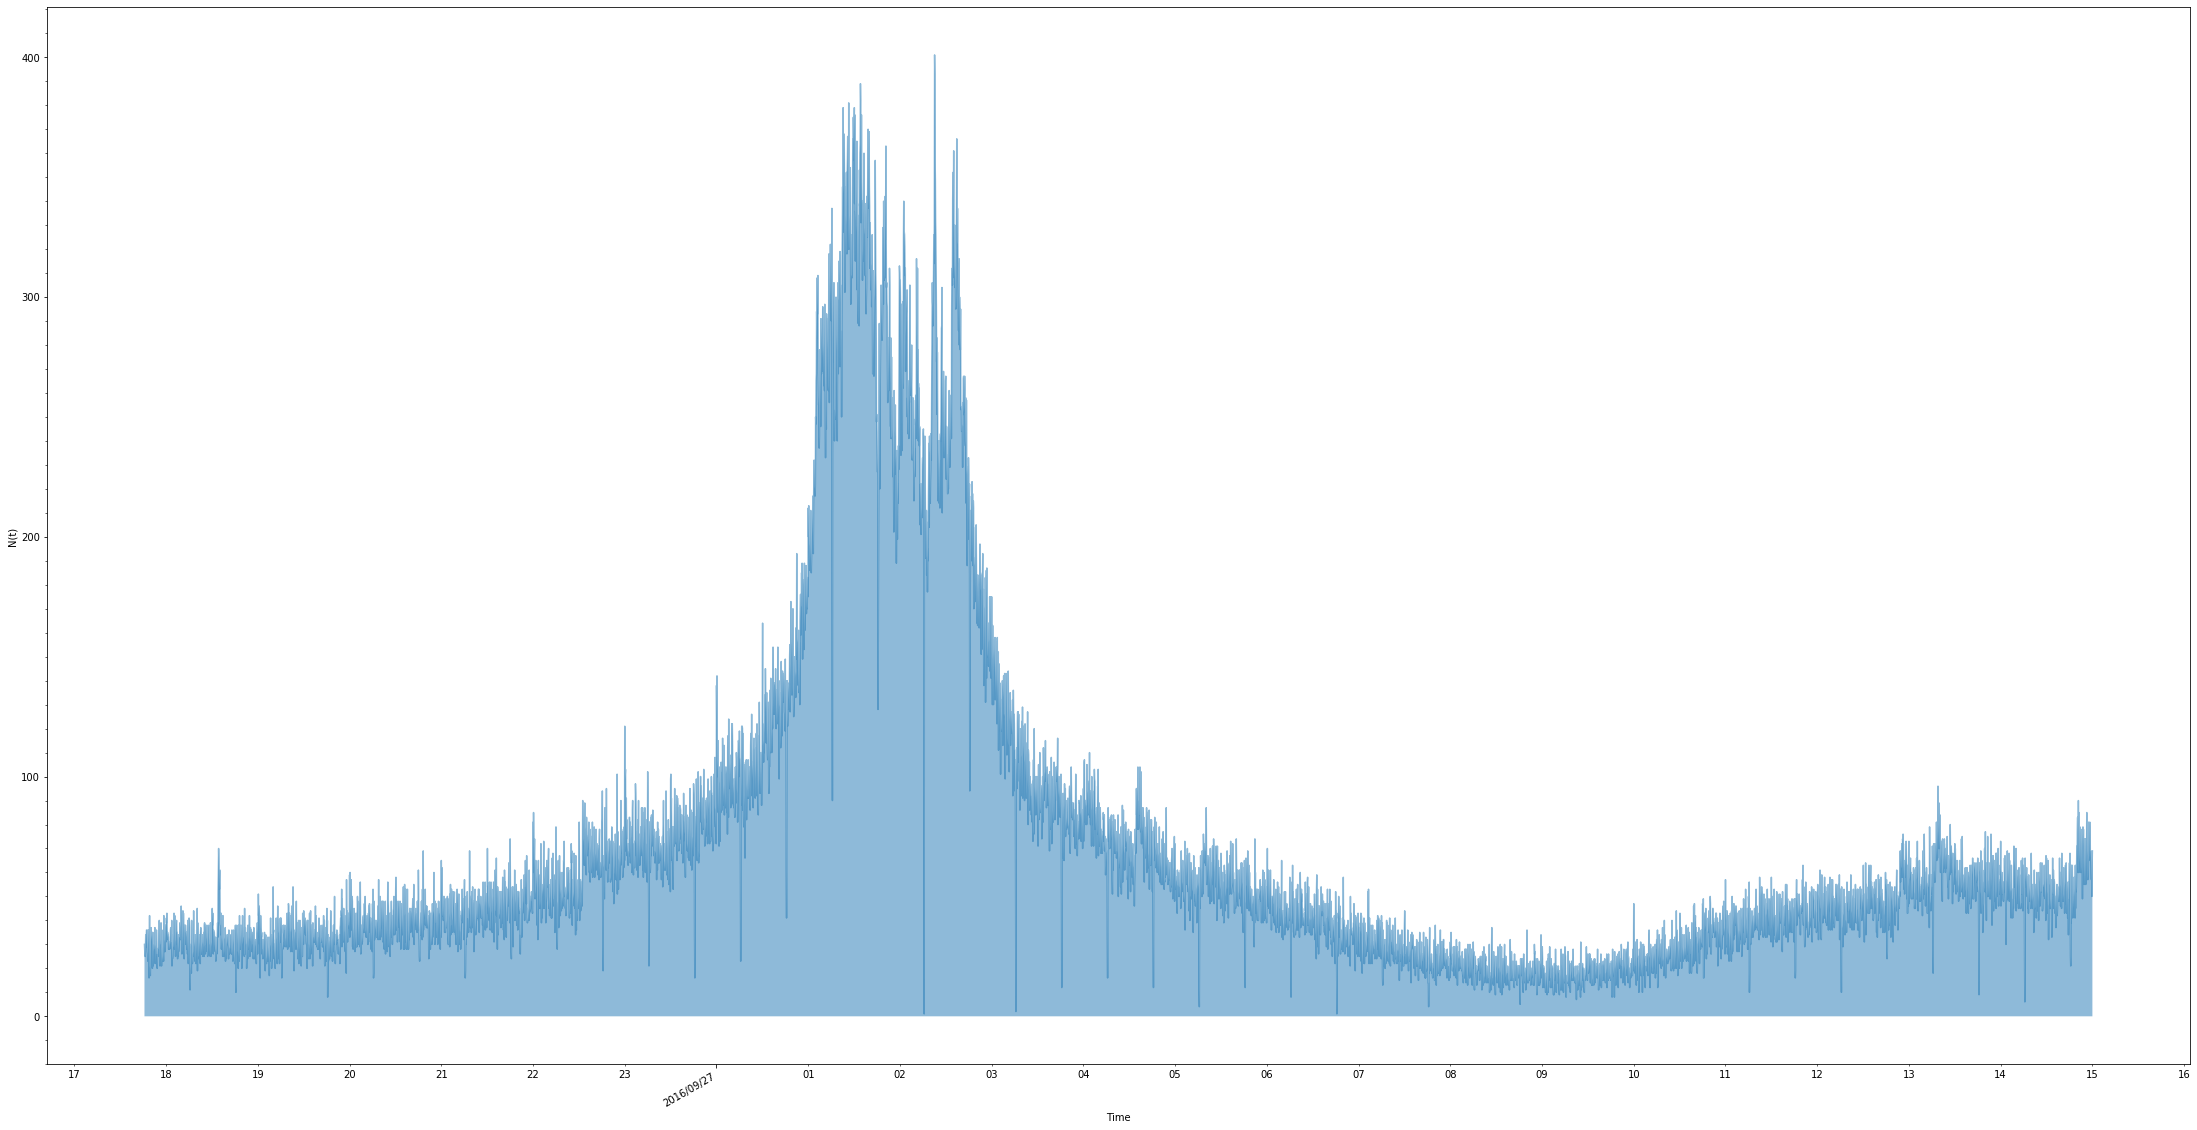

In [43]:
X, Y = Nt(zero)

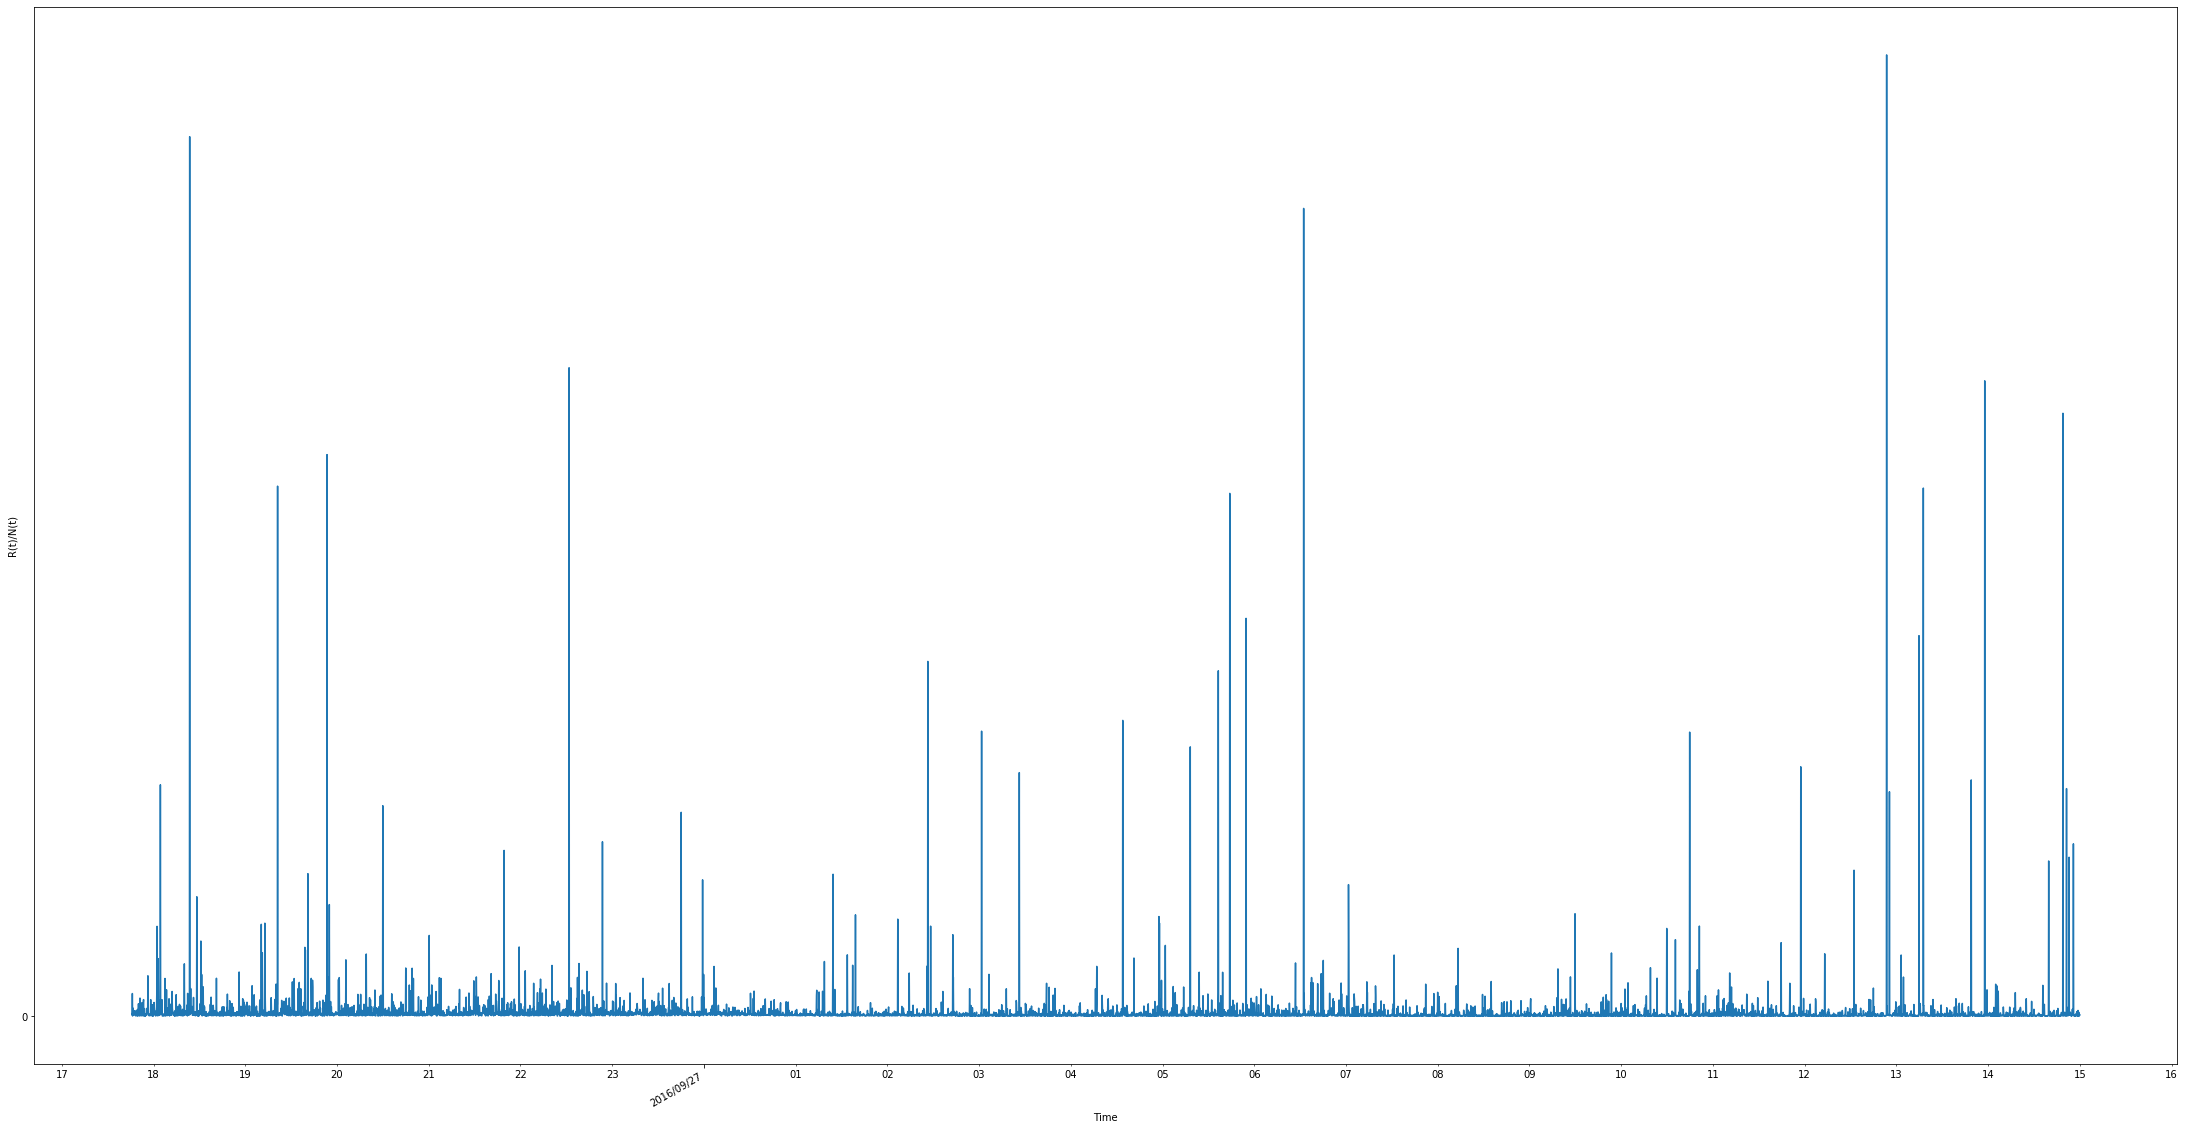

In [44]:
Xn, Yn = R_Nt(x, y, X, Y)

In [45]:
Ys_dfa = My_MFDFA(y, Y, Yn)

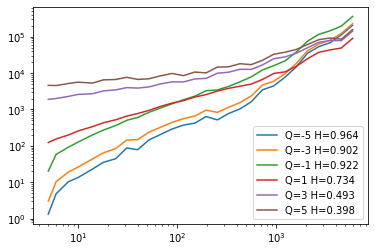

In [46]:
lag = np.logspace(0.7, 4, 30).astype(int)
Q = [-5, -5, -3, -3, -1, -1, 1, 1, 3, 3, 5, 5]

count = 0

while count <= len(Ys_dfa[0]) - 2:
    plt.loglog(lag, Ys_dfa[0][count], label=f"Q={Q[count]} H={round(Ys_dfa[0][count+1], 3)}")
    plt.legend()
    plt.savefig('MFDFA_Rt.svg', format='svg')
    count += 2

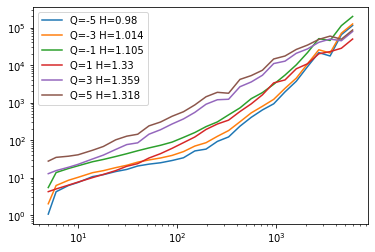

In [47]:
count = 0

while count <= len(Ys_dfa[1]) - 2:
    plt.loglog(lag, Ys_dfa[1][count], label=f"Q={Q[count]} H={round(Ys_dfa[1][count+1], 3)}")
    plt.legend()
    plt.savefig('MFDFA_Nt.svg', format='svg')
    count += 2

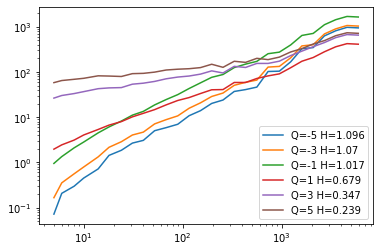

In [48]:
count = 0

while count <= len(Ys_dfa[2]) - 2:
    plt.loglog(lag, Ys_dfa[2][count], label=f"Q={Q[count]} H={round(Ys_dfa[2][count+1], 3)}")
    plt.legend()
    plt.savefig('MFDFA_R_nt.svg', format='svg')
    count += 2